Q1

The parameters of the largest circles:
[333.  281.    8.8]
Range of σ values used:
min: 2.0
max: 8.800000000000006


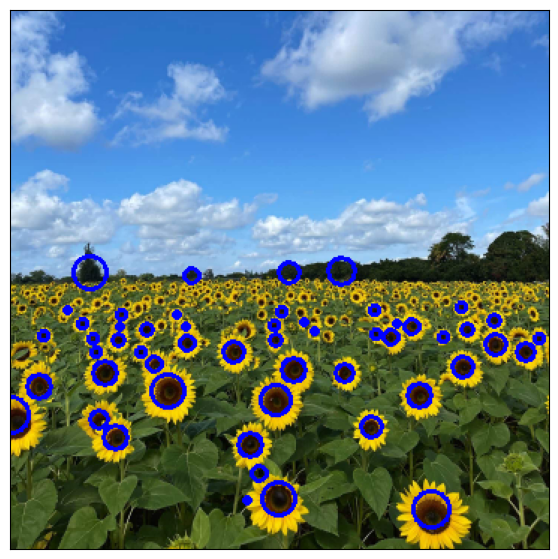

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
# Convert the image to grayscale
im_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)


def LoG(x,y,sigma):
    return (1/(2*np.pi*sigma**2))*((x**2+y**2)/(sigma**2)-2)*np.exp(-(x**2+y**2)/(2*sigma**2))

#create scale space
scale_space = []
sigma_range = np.arange(2,9,0.2)
for sigma in sigma_range:
    #create a kernel for the current sigma value
    kernel_size =int(sigma*5)
    if kernel_size%2 == 0:
        kernel_size += 1
    kernel = np.zeros((kernel_size,kernel_size))
    for x in range(kernel_size):
        for y in range(kernel_size):
            kernel[x,y] = LoG(x-kernel_size//2,y-kernel_size//2,sigma)
    #convolve the kernel with the image
    im_conv = cv.filter2D(im_gray,-1,kernel)
    scale_space.append((sigma,np.absolute(im_conv)))


# List to store the detected maxima
maxima = []
threshold = 0.63

for scale, scale_img in scale_space:
    max_val = np.max(scale_img)
    coordinates = np.argwhere(scale_img > threshold * max_val)
    for coord in coordinates:
        x, y = coord[0], coord[1]
        # Check if a point with same x,y exists 
        is_duplicate = False
        for existing_max in maxima:
            dist=np.sqrt((existing_max[0] - x)**2 + (existing_max[1] - y)**2)
            #check circles are intersecting
            if dist < (existing_max[2]*np.sqrt(2))+(scale*np.sqrt(2)):
                # if intersecting, check which one is bigger
                if scale > existing_max[2]:
                    existing_max[0] = x
                    existing_max[1] = y
                    existing_max[2] = scale

                is_duplicate = True
        if not is_duplicate:
            maxima.append([x, y, scale])



#draw blobs
for m in maxima:
    cv.circle(image, (m[1],m[0]), int(m[2]*np.sqrt(2)), (255,0,0), 2)


maxima = np.array(maxima)
maxima = maxima[maxima[:,2].argsort()]
print("The parameters of the largest circles:")
print(maxima[-1])
print("Range of σ values used:")
print("min:",sigma_range[0])
print("max:",sigma_range[-1])

#show the image
plt.figure(figsize=(7,7))
plt.imshow( cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.xticks([]),plt.yticks([])
plt.show()

    

Q2

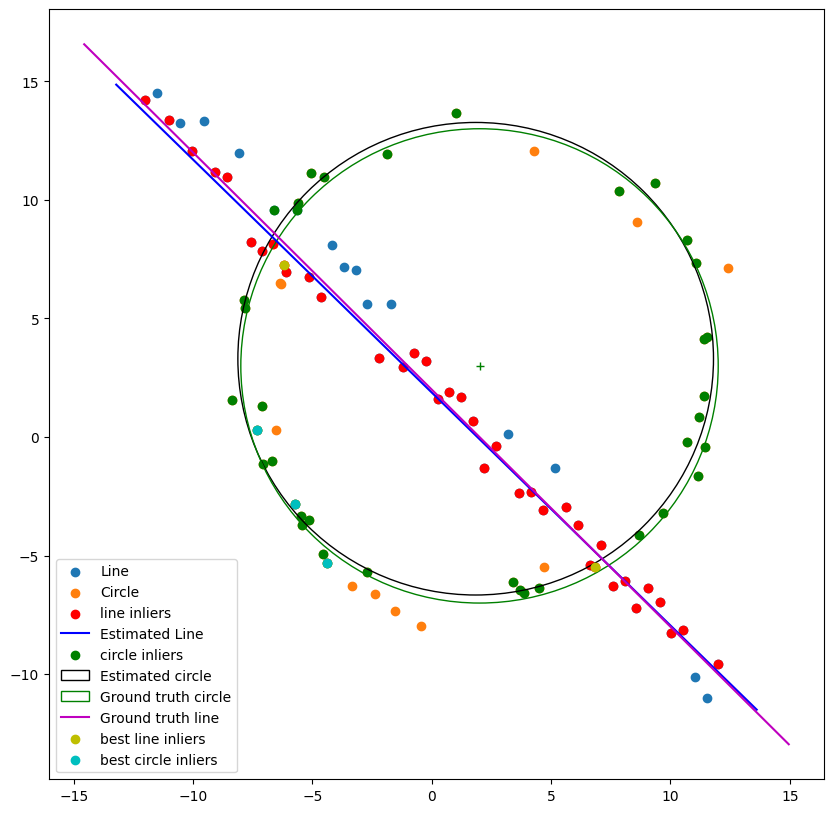

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points

######################################################################################################################


def total_LS(params, sample_indices):
    a, b, d = params
    distances = np.sum(np.square((a * X[sample_indices, 0] + b * X[sample_indices, 1] - d)))
    return distances

def constraint(params):
    a, b, _ = params
    return a**2 + b**2 - 1

def distance(params, X):
    a, b, d = params
    distances = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return distances


def fit_line_minimize(X, min_inliers=20, distance_threshold=1.3, num_iterations=100):
    best_a, best_b, best_d, best_inliers = None, None, None, None
    best_min_distance = float('inf')
    
    for i in range(num_iterations):
        # Randomly select 2 points from X
        sample_indices = np.random.randint(0, X.shape[0], 2)
        initial_params = [1, 0, 0]  
        constraint_dict = {'type': 'eq', 'fun': constraint}

        # decide line parameters
        result = minimize(fun=total_LS, args=sample_indices,x0=initial_params, constraints=constraint_dict)
        a, b, d = result.x

        norm = np.sqrt(a**2 + b**2)
        a /= norm
        b /= norm
        d /= norm

        # Calculate the distance from all points to the line
        distances = distance([a, b, d], X)
        # Find inliers 
        inliers = np.where(distances < distance_threshold)[0]

        # Update the best model 
        if len(inliers) >= min_inliers :
            b_result = minimize(fun=total_LS, args=inliers, x0=result.x, constraints=constraint_dict)
            if b_result.fun < best_min_distance:
                best_inliers = inliers
                best_a, best_b, best_d = b_result.x
                best_min_distance = b_result.fun

    return best_a, best_b, best_d, best_inliers


# Set the minimum number of inliers and distance threshold
min_inliers = 35
distance_threshold = 0.85

best_a, best_b, best_d, inliers = fit_line_minimize(X, min_inliers, distance_threshold, num_iterations=100)


############################################################################################################################

# Subtract the consensus of the best line (remnant)
if inliers is not None:
    remnant = np.delete(X, inliers, axis=0)
else:
    remnant = X.copy()


def circle_LS(params, remnant):
    x_center, y_center, radius = params
    distances = np.sum(np.square(np.sqrt((remnant[:, 0] - x_center) ** 2 + (remnant[:, 1] - y_center) ** 2) - radius))
    return distances

def cir_distance(params, remnant):
    x_center, y_center, radius = params
    distances = np.sqrt((remnant[:, 0] - x_center) ** 2 + (remnant[:, 1] - y_center) ** 2)
    return np.absolute(distances - radius)

def fit_circle_minimize(remnant, min_inliers=20, distance_threshold=1.3, num_iterations=100):
    best_x_center, best_y_center, best_radius, best_circle_inliers = None, None, None, None
    best_min_distance = float('inf')
    
    for i in range(num_iterations):
        # Randomly select 3 points from remnant
        sample_indices = np.random.randint(0, remnant.shape[0], 3)
        initial_params = [0, 0, 1]
        constraints_cir = [{'type': 'ineq', 'fun': lambda x: x[2] - distance_threshold}]

        # decide circle parameters
        result = minimize(fun=circle_LS, args=remnant[sample_indices],x0=initial_params, constraints=constraints_cir)
        x_center, y_center, radius = result.x

        # Calculate the distance from all points to the circle
        distances = cir_distance([x_center, y_center, radius], remnant)
        # Find inliers 
        inliers = np.where(distances < distance_threshold)[0]

        # Update the best model
        if len(inliers) >= min_inliers :
            b_result = minimize(fun=circle_LS, args=remnant[inliers], x0=result.x, constraints=constraints_cir)
            if b_result.fun < best_min_distance:
                best_circle_inliers = inliers
                best_x_center, best_y_center, best_radius = b_result.x
                best_min_distance = b_result.fun

    return best_x_center, best_y_center, best_radius, best_circle_inliers

min_circ_inliers = 38
circ_distance_threshold = 0.8
best_x_center, best_y_center, best_radius, best_circle_inliers = fit_circle_minimize(remnant, min_circ_inliers, circ_distance_threshold, num_iterations=100)
############################################################################################################################



fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

if inliers is not None:
    # Extract inliers from the dataset
    inlier_points = X[inliers]

    # Plot the inliers
    ax.scatter(inlier_points[:, 0], inlier_points[:, 1], c='r', marker='o', label='line inliers')

    # Plot the estimated line
    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = (-best_a / best_b) * x_ + (best_d / best_b)
    plt.plot(x_, y_, color='b', label='Estimated Line')

plt.legend()

if best_circle_inliers is not None:
    # Extract inliers from the dataset
    circle_inliers = remnant[best_circle_inliers]

    # Plot the inliers
    ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], c='g', marker='o', label='circle inliers')

    # Plot the estimated circle
    circle = plt.Circle((best_x_center, best_y_center), best_radius, color='k', fill=False, label='Estimated circle')
    ax.add_patch(circle)

plt.legend()

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

#display best samples
plt.scatter(X[inliers,0][:2],X[inliers,1][:2],c='y',label='best line inliers')
plt.scatter(remnant[best_circle_inliers,0][:3],remnant[best_circle_inliers,1][:3],c='c',label='best circle inliers')


plt.legend()

plt.show()


Q3

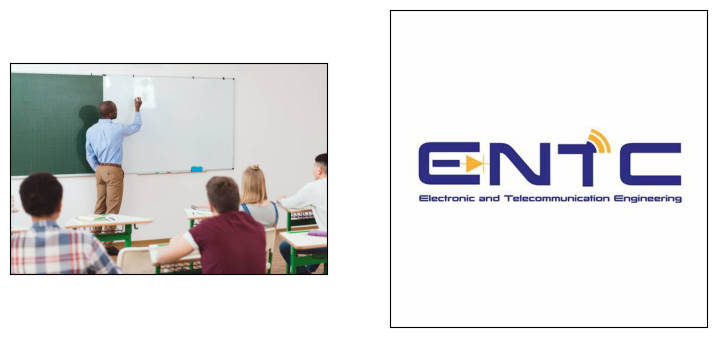

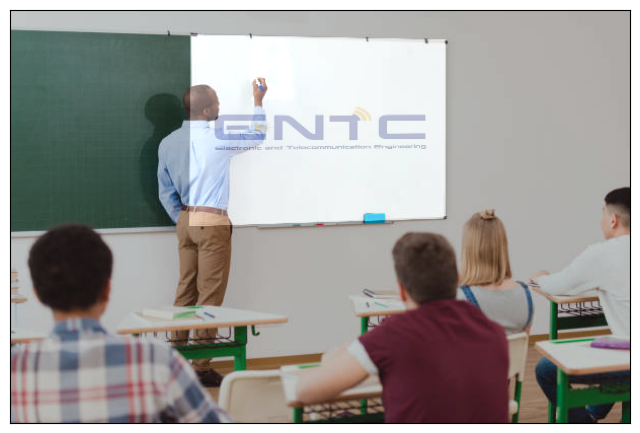

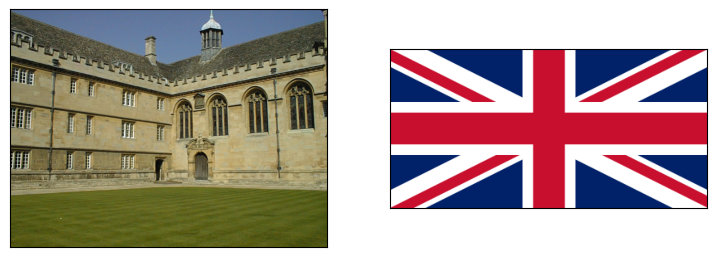

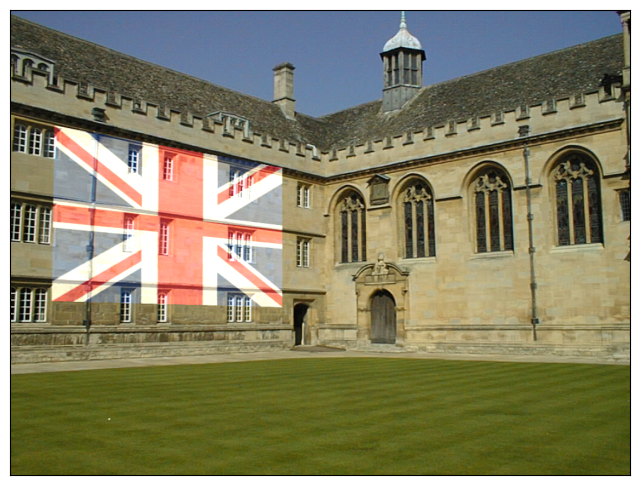

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def compute_homography(src_pts, dst_pts, svd_threshold=1e-6):
    A = []
    for i in range(4):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, x * u, y * u, u])
        A.append([0, 0, 0, -x, -y, -1, x * v, y * v, v])
    A = np.array(A)

    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1, :]  # Last row of Vt
    if np.abs(h).max() < svd_threshold:
        return None
    # Reshape h 
    H = h.reshape((3, 3))
    return H

arc_im = ['../assingment2/impose/board2.jpg','../assingment2/impose/001.jpg']
flag_im = ['../assingment2/impose/logo.jpg','../assingment2/impose/flag.png']
four_points = [[[178, 25], [430, 30], [430, 206],[177, 214]],[[70, 480], [74, 190], [450, 260],[450, 490]]]
weights= [[0.8,0.28],[1,0.6]]


for i in range(2):    
    # Read the images
    architectural_image = cv.imread(arc_im[i])
    flag_image = cv.imread(flag_im[i])

    architectural_points = np.array(four_points[i], dtype=np.float32)

    # corners of images
    flag_points = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)
    # Compute the homography matrix
    homography_matrix = compute_homography(flag_points, architectural_points)
    # Warp the flag image using the homography matrix
    flag_warped = cv.warpPerspective(flag_image, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))
    # Blend the images
    result = cv.addWeighted(architectural_image, weights[i][0], flag_warped,weights[i][1], 0)

    #Display the resul
    fig = plt.subplots(1,2,figsize=(9, 9))
    plt.subplot(121)
    plt.imshow( cv.cvtColor(architectural_image, cv.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow( cv.cvtColor(flag_image, cv.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])
    plt.show()
    plt.figure(figsize=(8, 8))  
    plt.imshow( cv.cvtColor(result, cv.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])
    plt.show()


Q4

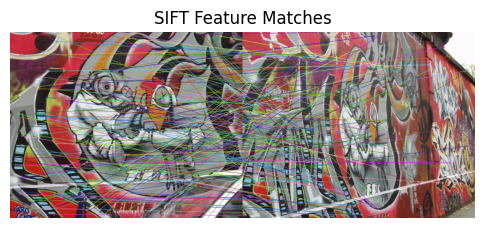

Computed Homography:
[[ 6.31407398e-01  3.31527911e-02  2.22854779e+02]
 [ 2.53683507e-01  1.11207274e+00 -1.98598926e+01]
 [ 5.45813423e-04 -1.17650933e-04  1.00000000e+00]]

Provided Homography:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


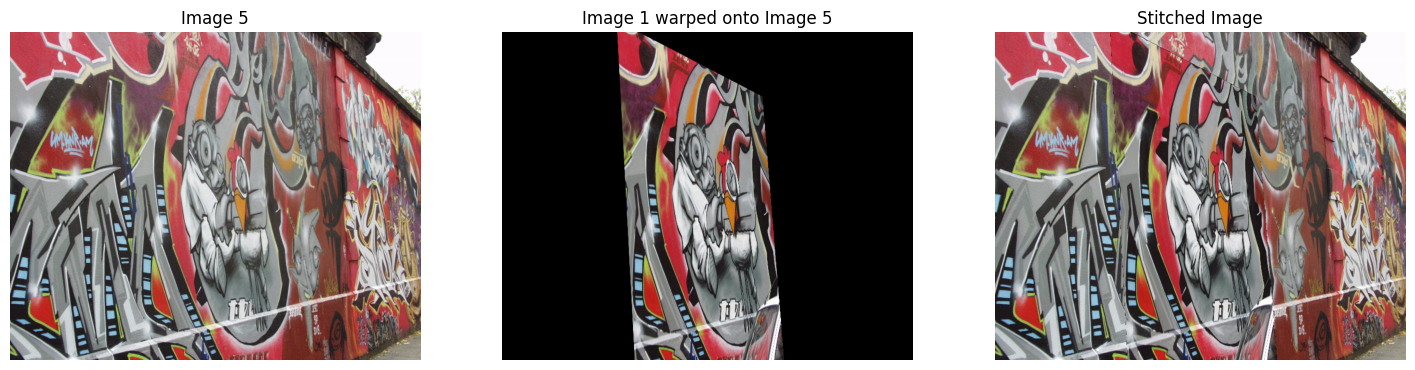

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('../assingment2/stitch/img1.ppm')
img5 = cv2.imread('../assingment2/stitch/img5.ppm')

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)


bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  # Feature matching
matches = sorted(bf.match(des1, des5), key=lambda x: x.distance)

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img5, kp5, matches[:200], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("SIFT Feature Matches")
plt.show()


src_pts = np.float32([kp1[k.queryIdx].pt for k in matches])
dst_pts = np.float32([kp5[k.trainIdx].pt for k in matches])


def homography_ransac(src_pts, dst_pts, ransac_threshold=5.0, max_trials=1000, svd_threshold=1e-6):

    if len(src_pts) < 4 or len(dst_pts) < 4:
        raise ValueError("At least 4 source and destination points are required.")

    best_H = None
    best_inliers = None
    best_num_inliers = 0

    for iteration in range(max_trials):
        # Randomly select 4 points 
        random_indices = np.random.choice(src_pts.shape[0], 4, replace=False)
        src_pts_random = src_pts[random_indices]
        dst_pts_random = dst_pts[random_indices]

        H = compute_homography(src_pts_random, dst_pts_random, svd_threshold)

        if H is None:
            continue

        src_pts_hom = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
        dst_pts_pred = np.dot(H, src_pts_hom.T).T
        dst_pts_pred /= dst_pts_pred[:, 2, None]  # Normalize


        distances = np.linalg.norm(dst_pts - dst_pts_pred[:, :2], axis=1)
        # Find the inliers
        inliers = np.where(distances < ransac_threshold)[0]
        num_inliers = len(inliers)

        # Update the best homography matrix
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_inliers = inliers
            best_H = H
            best_H=best_H/best_H[2,2]

    return best_H, best_inliers

def compute_homography(src_pts, dst_pts, svd_threshold):
    A = []
    for i in range(4):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, x * u, y * u, u])
        A.append([0, 0, 0, -x, -y, -1, x * v, y * v, v])
    A = np.array(A)

    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1, :]  # Last row of Vt
    if np.abs(h).max() < svd_threshold:
        return None

    # Reshape h 
    H = h.reshape((3, 3))
    return H



# Compute the homography using RANSAC
H, inliers = homography_ransac(src_pts, dst_pts, ransac_threshold=22, max_trials=500000)

#Compare the computed homography with the provided homography
provided_H = np.loadtxt('../assingment2/stitch/homography/H1to5p')
print("Computed Homography:")
print(H)
print("\nProvided Homography:")
print(provided_H)

# Warp img1 onto img5 using the computed homography
stitched_img = cv2.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))

#add images mask to cut img5 according to img1
mask = np.zeros(img5.shape, dtype=np.uint8)
mask[stitched_img[:, :, 0] != 0] = 255
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask_inv = cv2.bitwise_not(mask)
img5_masked = cv2.bitwise_and(img5, img5, mask=mask_inv)
result = cv2.add(stitched_img, img5_masked)





# Display the stitched image
plt.figure(figsize=(18, 18))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
plt.title("Image 5")
plt.axis('off')
# show img1 and img5
plt.subplot(132)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.title("Image 1 warped onto Image 5")
plt.axis('off')
plt.subplot(133)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Stitched Image")
plt.axis('off')
plt.show()


